In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from NeuralNetwork import NeuralNetwork
import numpy as np
import sklearn
from Config import cfg
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns

import pathlib

PATH = pathlib.Path("results/NN")
PATH.mkdir(exist_ok=True)

In [167]:
def add_polynomials(X, num_poly):
    poly = PolynomialFeatures(num_poly)
    X = poly.fit_transform(X)
    return X

def mse(pred, actual):
    return np.mean(np.square(pred - actual))

def R_squared(pred, actual):
        r_sq = 1 - mse(pred, actual)/ mse(actual.mean(), actual)
        return r_sq
    
def normalize_data(X_train, X_test, y_train, y_test, normalize_y = False):
    # Checking for constant column and removing it to keep it as ones
    condition = np.all(X_train[:,0] == 1)
    if condition:
        X_train = X_train[:,1:]
        X_test = X_test[:,1:]
    
    if normalize_y:
        
        train_data = np.concatenate((X_train, y_train.reshape(-1,1)), axis = 1)
        test_data = np.concatenate((X_test, y_test.reshape(-1,1)), axis = 1)
    
    else:
        train_data = X_train
        test_data = X_test

    # Scale data to 0 mean and 1 standard deviation
    scaler = StandardScaler(with_mean=True).fit(train_data)

    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    
    if normalize_y:
        
        y_train = train_data[:,-1]
        y_test = test_data[:,-1]

        X_train = train_data[:,:-1]
        X_test = test_data[:,:-1]
        
    else:
        X_train = train_data
        y_train = y_train
        
        X_test = test_data
        y_test = y_test

#     assert X_train.shape != train_data.shape

    # Adding back constant column if it was present
    if condition:
        X_train = np.concatenate([np.ones((len(X_train), 1)), X_train], axis = 1)
        X_test = np.concatenate([np.ones((len(X_test), 1)), X_test], axis = 1)

    return X_train, X_test, y_train, y_test


def model_eval(preds, actual):
    results = pd.DataFrame()
    results['preds'] = preds.flatten()
    results['targets'] = actual.flatten()
    results = results.sort_values('preds', ascending = False).reset_index(drop=True)
    results['model'] = np.cumsum(results.targets)
    results['optimal'] = results.targets.sort_values(ascending = False).values
    results['best_curve'] = np.cumsum(results.optimal)
    step = np.sum(results.targets).astype('float') / len(results)
    results['baseline'] = np.arange(start = step,stop = np.sum(results.targets)+step, step = step)
    results['model_diff'] = results.model - results.baseline
    results['optimal_diff'] = results.best_curve - results.baseline
    return results

def area_ratio(pred, actual):
    res = model_eval(pred, actual)
    return res.model_diff.sum() / res.optimal_diff.sum()

def get_area_ratios(model_list, X_train, X_test, y_train, y_test):
    area_ratios = []
    for model in model_list:
        test_pred = model.predict(X_test)
        train_pred = model.predict(X_train)

        ar = area_ratio(test_pred, y_test), area_ratio(train_pred, y_train)
        area_ratios.append(ar)
    return area_ratios

def get_mses(model_list, X_train, X_test, y_train, y_test):
    mses = []
    for model in model_list:
        test_pred = model.predict(X_test)
        train_pred = model.predict(X_train)
        
        mse_ = mse(test_pred, y_test), mse(train_pred, y_train)
        mses.append(mse_)
    return mses


def plot_lift(pred, actual, save_name):
    results = model_eval(pred, actual)
    fig, ax = plt.subplots(figsize = (12,10))
    results[['model', 'best_curve', 'baseline']].plot(ax = ax, linewidth = 3, alpha = 0.8)
    plt.xlabel("Number of total data", fontsize = 20)
    plt.ylabel("Cumulative number of target data", fontsize = 20)
    plt.title("Lift chart", fontsize = 20)
    fig.savefig(PATH.joinpath(f"lift plot for {save_name}.png"))
    plt.show()
    
def plot_3d_results(X, Y, results, save_as, metric = 'test_mse'):
    def fun(x, y):
        row = results[(results.p1 == x) & (results.p2 == y)]
        return row[metric].tolist()[0]

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(X, Y)
    zs = np.array([fun(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
    X = np.log10(X)
    Y = np.log10(Y)

    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, label = 'Test')

    ax.set_xlabel('Lambda (Log10)', fontsize = 20)
    ax.set_ylabel('Learning rate (Log10)', fontsize = 20)
    ax.set_zlabel('Test Area Ratio', fontsize = 20)
    
    plt.title("Parameter search", fontsize = 20)
    
    plt.show()
    fig.savefig(PATH.joinpath(f'{save_as}.png'))
    
def plot_3d_results_regression(X, Y, results, save_as, metric = 'test_mse'):
    def fun(x, y):
        row = results[(results.p1 == x) & (results.p2 == y)]
        return row[metric].tolist()[0]

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(X, Y)
    zs = np.array([fun(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
    X = np.log10(X)
    Y = np.log10(Y)

    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z, label = 'Test')

    ax.set_xlabel('Lambda (Log10)', fontsize = 20)
    ax.set_ylabel('Learning rate (Log10)', fontsize = 20)
    ax.set_zlabel('Test Error', fontsize = 20)
    
    plt.title("Parameter search", fontsize = 20)
    
    plt.show()
    fig.savefig(PATH.joinpath(f'{save_as}.png'))
    
def result_table_classification(train_pred, train_act, test_pred, test_act):
    AR = np.array([area_ratio(test_pred, test_act), 
               area_ratio(train_pred, train_act)]).reshape(1,2)
    acc_f = lambda x, y : ((x > 0.5) == y).mean()
    acc = np.array([acc_f(test_pred, test_act), 
          acc_f(train_pred, train_act)]).reshape(1,2)
    
    return pd.DataFrame(np.concatenate((AR, acc), axis = 0), columns = ["Test", "Train"],
                        index = ['Area ratio', "Accuracy"])

def prepare_credit_data():
    df = pd.read_excel("data/default of credit card clients.xls")
    df = df.iloc[1:, 1:]
    categorical = ['X2', 'X3', 'X4']


    X = df.drop('Y', axis = 1)
    y = df.Y.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    columns = X_train.columns
    encode = [True if i in categorical else False for i in columns]
    enc = OneHotEncoder(categorical_features = encode)
    enc.fit(X_train)

    X_train = enc.transform(X_train).toarray()
    X_test = enc.transform(X_test).toarray()

    X_train, X_test, y_train, y_test = normalize_data( X_train, X_test, y_train, y_test)
    X_train = X_train.astype('float')
    X_test = X_test.astype('float')

    y_test = y_test.astype('float').reshape(-1,1)
    y_train = y_train.astype('float').reshape(-1,1)
    
    return X_train, X_test, y_train, y_test

# Credit card data

In [135]:
X_train, X_test, y_train, y_test = prepare_credit_data()

C:\Users\johan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\johan\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


# Neural Network paramater search

In [141]:
# Testing different lambdas
models = []
for i in [10**l for l in range(-3,2)]:
    nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                       [100, 100,1], 
                       ['relu', 'relu','sigmoid'], 
                       'logistic')
    nn.train(512, 300, 0.01, i)
    
    models.append(nn)
    print(len(models))

EPOCH 0 :
logistic cost: 0.5744600337251882
validaltion logistic cost: 0.5777954183791157


EPOCH 30 :
logistic cost: 0.4502980738041601
validaltion logistic cost: 0.4556973163955857


EPOCH 60 :
logistic cost: 0.4371263700265712
validaltion logistic cost: 0.44544048289900456


EPOCH 90 :
logistic cost: 0.4335807004686662
validaltion logistic cost: 0.4409991060169945


EPOCH 120 :
logistic cost: 0.4323245965730396
validaltion logistic cost: 0.43832605604265884


EPOCH 150 :
logistic cost: 0.4318577340534088
validaltion logistic cost: 0.4367731732247345


EPOCH 180 :
logistic cost: 0.43196636464194244
validaltion logistic cost: 0.4358157960947278


EPOCH 210 :
logistic cost: 0.43198424476460173
validaltion logistic cost: 0.43519015677780337


EPOCH 240 :
logistic cost: 0.43185531888666145
validaltion logistic cost: 0.434727415908056


EPOCH 270 :
logistic cost: 0.4318034292783363
validaltion logistic cost: 0.434455043807715


EPOCH 299 :
logistic cost: 0.43160480663746775
validaltion lo

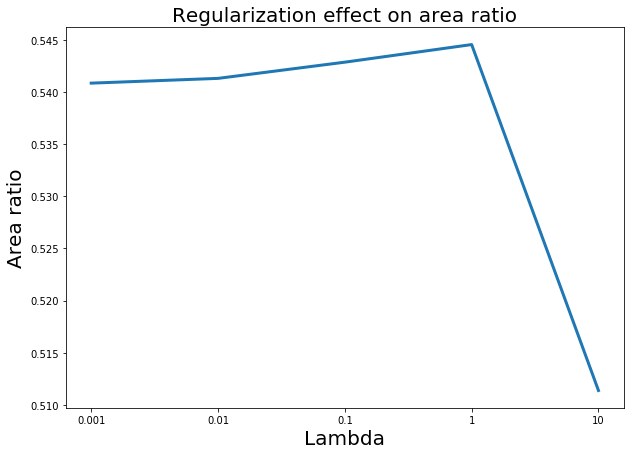

In [142]:
area_ratios = get_area_ratios(models, X_train, X_test, y_train, y_test)

fig, ax = plt.subplots(figsize = (10,7))
plt.plot(np.log10([10**l for l in range(-3,2)]), [i[0] for i in area_ratios],
        linewidth = 3)

plt.title("Regularization effect on area ratio", fontsize = 20)
plt.ylabel("Area ratio", fontsize = 20)
plt.xlabel("Lambda", fontsize = 20)
plt.xticks([i for i in range(-3,2)], [10**l for l in range(-3,2)])
fig.savefig(PATH.joinpath("Regularization effect on area ratio.png"))

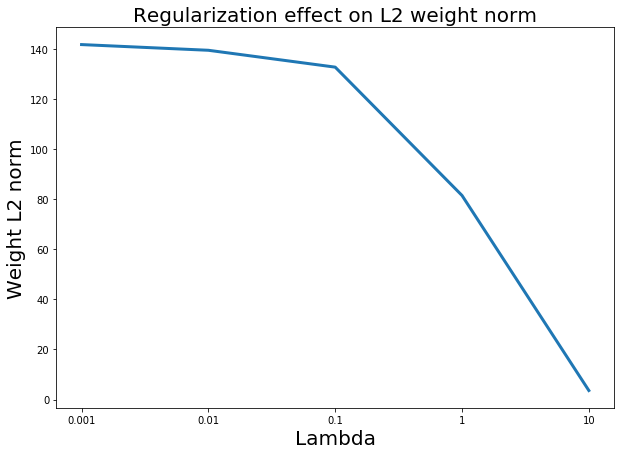

In [143]:
# Checking regularization parameter effect on weight norm
weight_l2 = []
for model in models:
    s = 0
    for layer in model.layers:
        s += np.sum(layer.W**2)
    weight_l2.append(s)

fig, ax = plt.subplots(figsize = (10,7))
plt.plot(np.log10([10**l for l in range(-3,2)]), weight_l2,
        linewidth = 3)
plt.title("Regularization effect on L2 weight norm", fontsize = 20)
plt.ylabel("Weight L2 norm", fontsize = 20)
plt.xlabel("Lambda", fontsize = 20)
plt.xticks([i for i in range(-3,2)], [10**l for l in range(-3,2)])
fig.savefig(PATH.joinpath("Regularization effect on weight norm.png"))

# Learning rate / lambda plot

In [ ]:
# Examining learning rate and lambda grid
models = []
p1 = [10**l for l in range(-3,2)] # regularization
p2 = [0.001, 0.01, 0.1] # Learning rate
grid = []
for i in p1:
    for j in p2:
        nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                           [100, 100,1], 
                           ['relu', 'relu','sigmoid'], 
                           'logistic')
        nn.train(512, 300, j, i)
        grid.append([i,j])
        models.append(nn)

area_ratios = get_area_ratios(models, X_train, X_test, y_train, y_test)

grid = np.array(grid)
area_ratios = np.array([[i, j] for i, j in area_ratios])
results = np.concatenate((grid, area_ratios), axis = 1)
results = pd.DataFrame(results, columns = ['p1', 'p2', 'test_AR', 'train_AR'])

results.to_csv(PATH.joinpath("3d_plot_data.csv"))

In [144]:
results = pd.read_csv(PATH.joinpath("3d_plot_data.csv"))
plot_3d_results(X = p1, Y = p2, results = results,  
                metric = "test_AR", 
               save_as = "parameter_search_NN")

EPOCH 0 :
logistic cost: 0.6151336960599371
validaltion logistic cost: 0.6193593627423878


EPOCH 30 :
logistic cost: 0.5160350771807902
validaltion logistic cost: 0.5252856665772732


EPOCH 60 :
logistic cost: 0.4979069807968224
validaltion logistic cost: 0.5077766414009666


EPOCH 90 :
logistic cost: 0.4873044740484785
validaltion logistic cost: 0.49740462041280187


EPOCH 120 :
logistic cost: 0.47962854801484284
validaltion logistic cost: 0.489978651730171


EPOCH 150 :
logistic cost: 0.4735856786331314
validaltion logistic cost: 0.4842727149620153


EPOCH 180 :
logistic cost: 0.46856441904542717
validaltion logistic cost: 0.4796441121708079


EPOCH 210 :
logistic cost: 0.46429574507800847
validaltion logistic cost: 0.4757182304132262


EPOCH 240 :
logistic cost: 0.4605818819785278
validaltion logistic cost: 0.4723233653421619


EPOCH 270 :
logistic cost: 0.4573445919175837
validaltion logistic cost: 0.46934621654415803


EPOCH 299 :
logistic cost: 0.45456331141761336
validaltion lo

EPOCH 0 :
logistic cost: 0.4759720197478199
validaltion logistic cost: 0.4835448017675263


EPOCH 30 :
logistic cost: 0.4276801974900596
validaltion logistic cost: 0.43497660339073163


EPOCH 60 :
logistic cost: 0.42049560013817683
validaltion logistic cost: 0.4339267890619511


EPOCH 90 :
logistic cost: 0.4126673998700426
validaltion logistic cost: 0.4348720135461987


EPOCH 120 :
logistic cost: 0.40562554117732663
validaltion logistic cost: 0.43678053271291706


EPOCH 150 :
logistic cost: 0.3968593899239629
validaltion logistic cost: 0.4393331054272833


EPOCH 180 :
logistic cost: 0.3892345881058727
validaltion logistic cost: 0.4414091667629195


EPOCH 210 :
logistic cost: 0.3818681573864839
validaltion logistic cost: 0.4439316631061204


EPOCH 240 :
logistic cost: 0.3758072869215364
validaltion logistic cost: 0.44644586302573347


EPOCH 270 :
logistic cost: 0.3692789146874401
validaltion logistic cost: 0.44884622826656095


EPOCH 299 :
logistic cost: 0.36383519328184505
validaltion 

# Best neural network model

In [147]:
# Locate best parameter setting
results = pd.read_csv(PATH.joinpath("3d_plot_data.csv"))
params = results[results.test_AR == results.test_AR.max()]

nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                       [100, 100,1], 
                       ['relu', 'relu','sigmoid'], 
                       'logistic')
nn.train(512, 300, learning_rate = params.p2.values[0], l2_lambda = params.p1.values[0], keep_history = True)

EPOCH 0 :
logistic cost: 0.5700342050002359
validaltion logistic cost: 0.5705205842214477


EPOCH 30 :
logistic cost: 0.4556869453225953
validaltion logistic cost: 0.4586411165419585


EPOCH 60 :
logistic cost: 0.442329976858301
validaltion logistic cost: 0.4463465945917114


EPOCH 90 :
logistic cost: 0.439455544584353
validaltion logistic cost: 0.44163793974993815


EPOCH 120 :
logistic cost: 0.4377216236346572
validaltion logistic cost: 0.4386160837703642


EPOCH 150 :
logistic cost: 0.43613576902540263
validaltion logistic cost: 0.4365480145331469


EPOCH 180 :
logistic cost: 0.43443685961394424
validaltion logistic cost: 0.4350384116588441


EPOCH 210 :
logistic cost: 0.43288732436935423
validaltion logistic cost: 0.43389769861782806


EPOCH 240 :
logistic cost: 0.4315389707979967
validaltion logistic cost: 0.4331165143437542


EPOCH 270 :
logistic cost: 0.4304029577278091
validaltion logistic cost: 0.432586921807167


EPOCH 299 :
logistic cost: 0.4293658872923067
validaltion logis

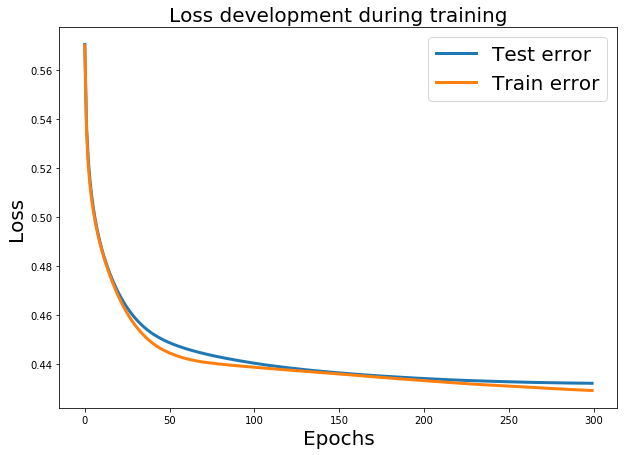

In [148]:
# Examine loss development during training
fig, ax = plt.subplots(figsize = (10,7))
plt.plot([i[0] for i in nn.history], [i[1] for i in nn.history], label = "Test error",linewidth = 3)
plt.plot([i[0] for i in nn.history], [i[2] for i in nn.history], label = "Train error", linewidth = 3)
plt.legend(prop={'size': 20})
plt.title("Loss development during training", fontsize = 20)
plt.ylabel("Loss", fontsize = 20)
plt.xlabel("Epochs", fontsize = 20)
fig.savefig(PATH.joinpath("Loss development during training NN.png"))

In [149]:
test_pred = nn.predict(X_test)
train_pred = nn.predict(X_train)

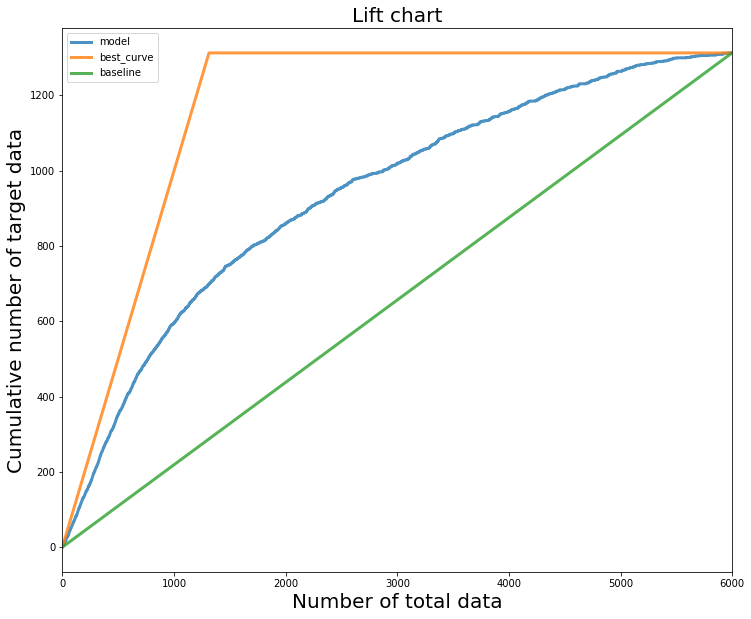

In [150]:
plot_lift(test_pred, y_test, "test")

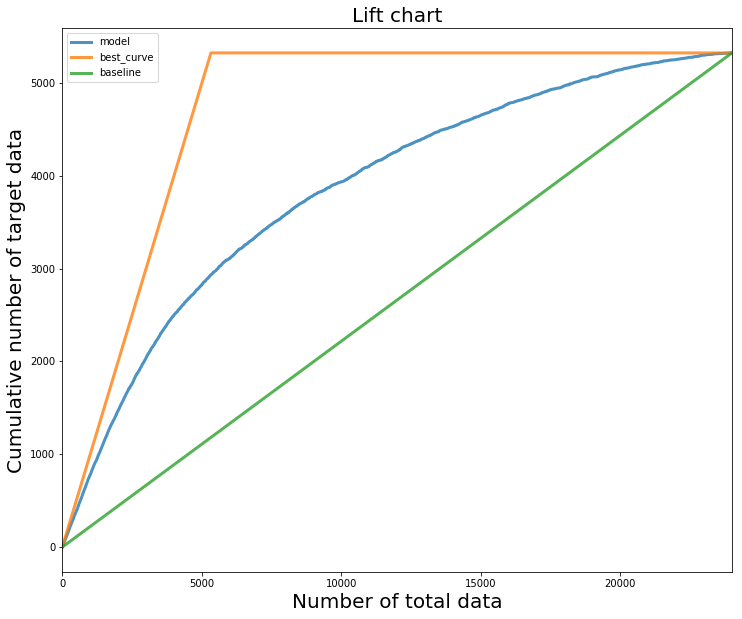

In [151]:
plot_lift(train_pred, y_train, 'train')

In [152]:
result_table_classification(train_pred, y_train, test_pred, y_test).to_csv(PATH.joinpath("NN_model_score.csv"))

# Franke data

In [153]:
df = pd.read_csv(cfg.FRANKE_DATA)

df = df[['x1', 'x2', 'y']]
ind = [i for i in range(len(df))]
np.random.shuffle(ind)
ind = ind[:10000]

split_point = int(0.8*len(ind))
train = ind[:split_point]
test = ind[split_point : ]

train = df.iloc[train]
test = df.iloc[test]

X_train = train.drop('y', axis = 1).values
X_test = test.drop('y', axis = 1).values
y_train = train.y.values
y_test = test.y.values

X_train, X_test, y_train, y_test = normalize_data(X_train, X_test, y_train, y_test, True)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [178]:
# Examining learning rate and lambda grid
models = []
p1 = [10**l for l in range(-2,2)] # regularization
p2 = [0.01, 0.1, 1] # Learning rate
grid = []
for i in p1:
    for j in p2:
        nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                   [300, 100, 50, 20, 10, 1], 
                   ['relu', 'relu','relu', 'relu','relu', 'linear'], 
                   'mse')
        nn.train(512, 100, j, i)
        grid.append([i,j])
        models.append(nn)

EPOCH 0 :
mse cost: 0.49941343183690073
validaltion mse cost: 0.5147808147243589


EPOCH 10 :
mse cost: 0.48604600062326603
validaltion mse cost: 0.5012196205177759


EPOCH 20 :
mse cost: 0.4822255404971951
validaltion mse cost: 0.4972972617588615


EPOCH 30 :
mse cost: 0.4739147008315232
validaltion mse cost: 0.4888411413328582


EPOCH 40 :
mse cost: 0.4492710181489845
validaltion mse cost: 0.46380105277379313


EPOCH 50 :
mse cost: 0.3638152275467741
validaltion mse cost: 0.3767085649553911


EPOCH 60 :
mse cost: 0.16327415116114796
validaltion mse cost: 0.16923945979300575


EPOCH 70 :
mse cost: 0.08244442991172274
validaltion mse cost: 0.08343024296536981


EPOCH 80 :
mse cost: 0.05568909541087015
validaltion mse cost: 0.057524833239934264


EPOCH 90 :
mse cost: 0.04116699939123135
validaltion mse cost: 0.04358194900890123


EPOCH 99 :
mse cost: 0.03270545509820509
validaltion mse cost: 0.03560998813411097


EPOCH 0 :
mse cost: 0.48719756621456867
validaltion mse cost: 0.5024048947

EPOCH 90 :
mse cost: 0.48901673567190984
validaltion mse cost: 0.5042636635928412


EPOCH 99 :
mse cost: 0.48901673567190984
validaltion mse cost: 0.5042636635928412


EPOCH 0 :
mse cost: 0.49545113927358414
validaltion mse cost: 0.5103776408623317


EPOCH 10 :
mse cost: 0.4822866074844871
validaltion mse cost: 0.4973203722576906


EPOCH 20 :
mse cost: 0.4750137416098033
validaltion mse cost: 0.48997828909517216


EPOCH 30 :
mse cost: 0.4610435032869057
validaltion mse cost: 0.47577645545145325


EPOCH 40 :
mse cost: 0.4192115737865668
validaltion mse cost: 0.43341500952469075


EPOCH 50 :
mse cost: 0.2918476741523145
validaltion mse cost: 0.30417554153308707


EPOCH 60 :
mse cost: 0.15076537543518476
validaltion mse cost: 0.15720306492426717


EPOCH 70 :
mse cost: 0.09936801846749652
validaltion mse cost: 0.10190331885194732


EPOCH 80 :
mse cost: 0.07537923707172425
validaltion mse cost: 0.07679031352471541


EPOCH 90 :
mse cost: 0.060681822261145844
validaltion mse cost: 0.061896732

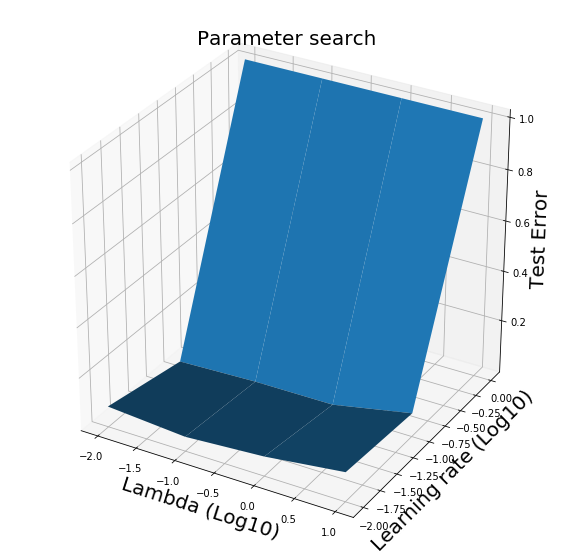

In [179]:
mses = get_mses(models, X_train, X_test, y_train, y_test)

grid = np.array(grid)
mses = np.array([[i, j] for i, j in mses])
results = np.concatenate((grid, mses), axis = 1)
results = pd.DataFrame(results, columns = ['p1', 'p2', 'test_mse', 'train_mse'])

results.to_csv(PATH.joinpath("3d_plot_data_FRANKE.csv"))

results = pd.read_csv(PATH.joinpath("3d_plot_data_FRANKE.csv"))
plot_3d_results_regression(X = p1, Y = p2, results = results,  
                metric = "test_mse", 
               save_as = "parameter_search_NN_FRANKE")

In [154]:
nn = NeuralNetwork(X_train, y_train, (X_test, y_test), 
                   [300, 100, 50, 20, 10, 1], 
                   ['relu', 'relu','relu', 'relu','relu', 'linear'], 
                   'mse')

In [155]:
nn.train(512, 1000, 0.01)

EPOCH 0 :
mse cost: 0.49529477338482175
validaltion mse cost: 0.5103962769788576


EPOCH 100 :
mse cost: 0.04163430198052536
validaltion mse cost: 0.0441191572585878


EPOCH 200 :
mse cost: 0.008247603909904196
validaltion mse cost: 0.011254604103500054


EPOCH 300 :
mse cost: 0.0033612192978593387
validaltion mse cost: 0.004752858072269706


EPOCH 400 :
mse cost: 0.0015338139040751316
validaltion mse cost: 0.002361985974823985


EPOCH 500 :
mse cost: 0.0009684321195627457
validaltion mse cost: 0.001620402749871088


EPOCH 600 :
mse cost: 0.0007277509672797258
validaltion mse cost: 0.001290860357287006


EPOCH 700 :
mse cost: 0.0005979726126571663
validaltion mse cost: 0.0010798133223952045


EPOCH 800 :
mse cost: 0.0005054196253460184
validaltion mse cost: 0.0009139412827138533


EPOCH 900 :
mse cost: 0.00042377160161244316
validaltion mse cost: 0.0007711531810429468


EPOCH 999 :
mse cost: 0.0003413994216125127
validaltion mse cost: 0.0006346303872447643




In [156]:
mse(nn.predict(X_test), y_test), mse(nn.predict(X_train), y_train)

(0.0012692607744895286, 0.001052481656251971)

In [157]:
pd.DataFrame(np.array([R_squared(nn.predict(X_test), y_test), 
                       R_squared(nn.predict(X_train), y_train)]).reshape(1,2), 
            columns = ["Test", "Train"], index = ["R squared"])\
        .to_csv(PATH.joinpath("franke_NN_results.csv"))

# Keras comparison

In [158]:
import tensorflow as tf
from tensorflow import keras

inp = keras.layers.Input(shape = (2,))
i = 0
for size, activation in zip([300, 100, 50, 20, 10, 1], ['relu', 'relu','relu', 'relu','relu', 'linear']):
    if i == 0:
        L = keras.layers.Dense(size, activation = activation)(inp)
    else:
        L = keras.layers.Dense(size, activation = activation)(L)
    i+=1

model = keras.Model(inputs=inp, outputs=L)
opt = tf.keras.optimizers.SGD()
model.compile(optimizer = opt, loss = 'mse')
model.fit(x = X_train, y = y_train, epochs = 1000, verbose = 0, batch_size=512)

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

mse(train_preds, y_train), mse(test_preds, y_test)

(0.00020427465140740724, 0.00023580688298424645)

In [159]:
R_squared(nn.predict(X_test), y_test), R_squared(nn.predict(X_train), y_train)

(0.9987414699229308, 0.9989475183437481)